This notebook is the third part of an introduction to machine learning and implements, and improve, the the model from Part II to recognize handwritten digit from the MNIST, using PyTorch.

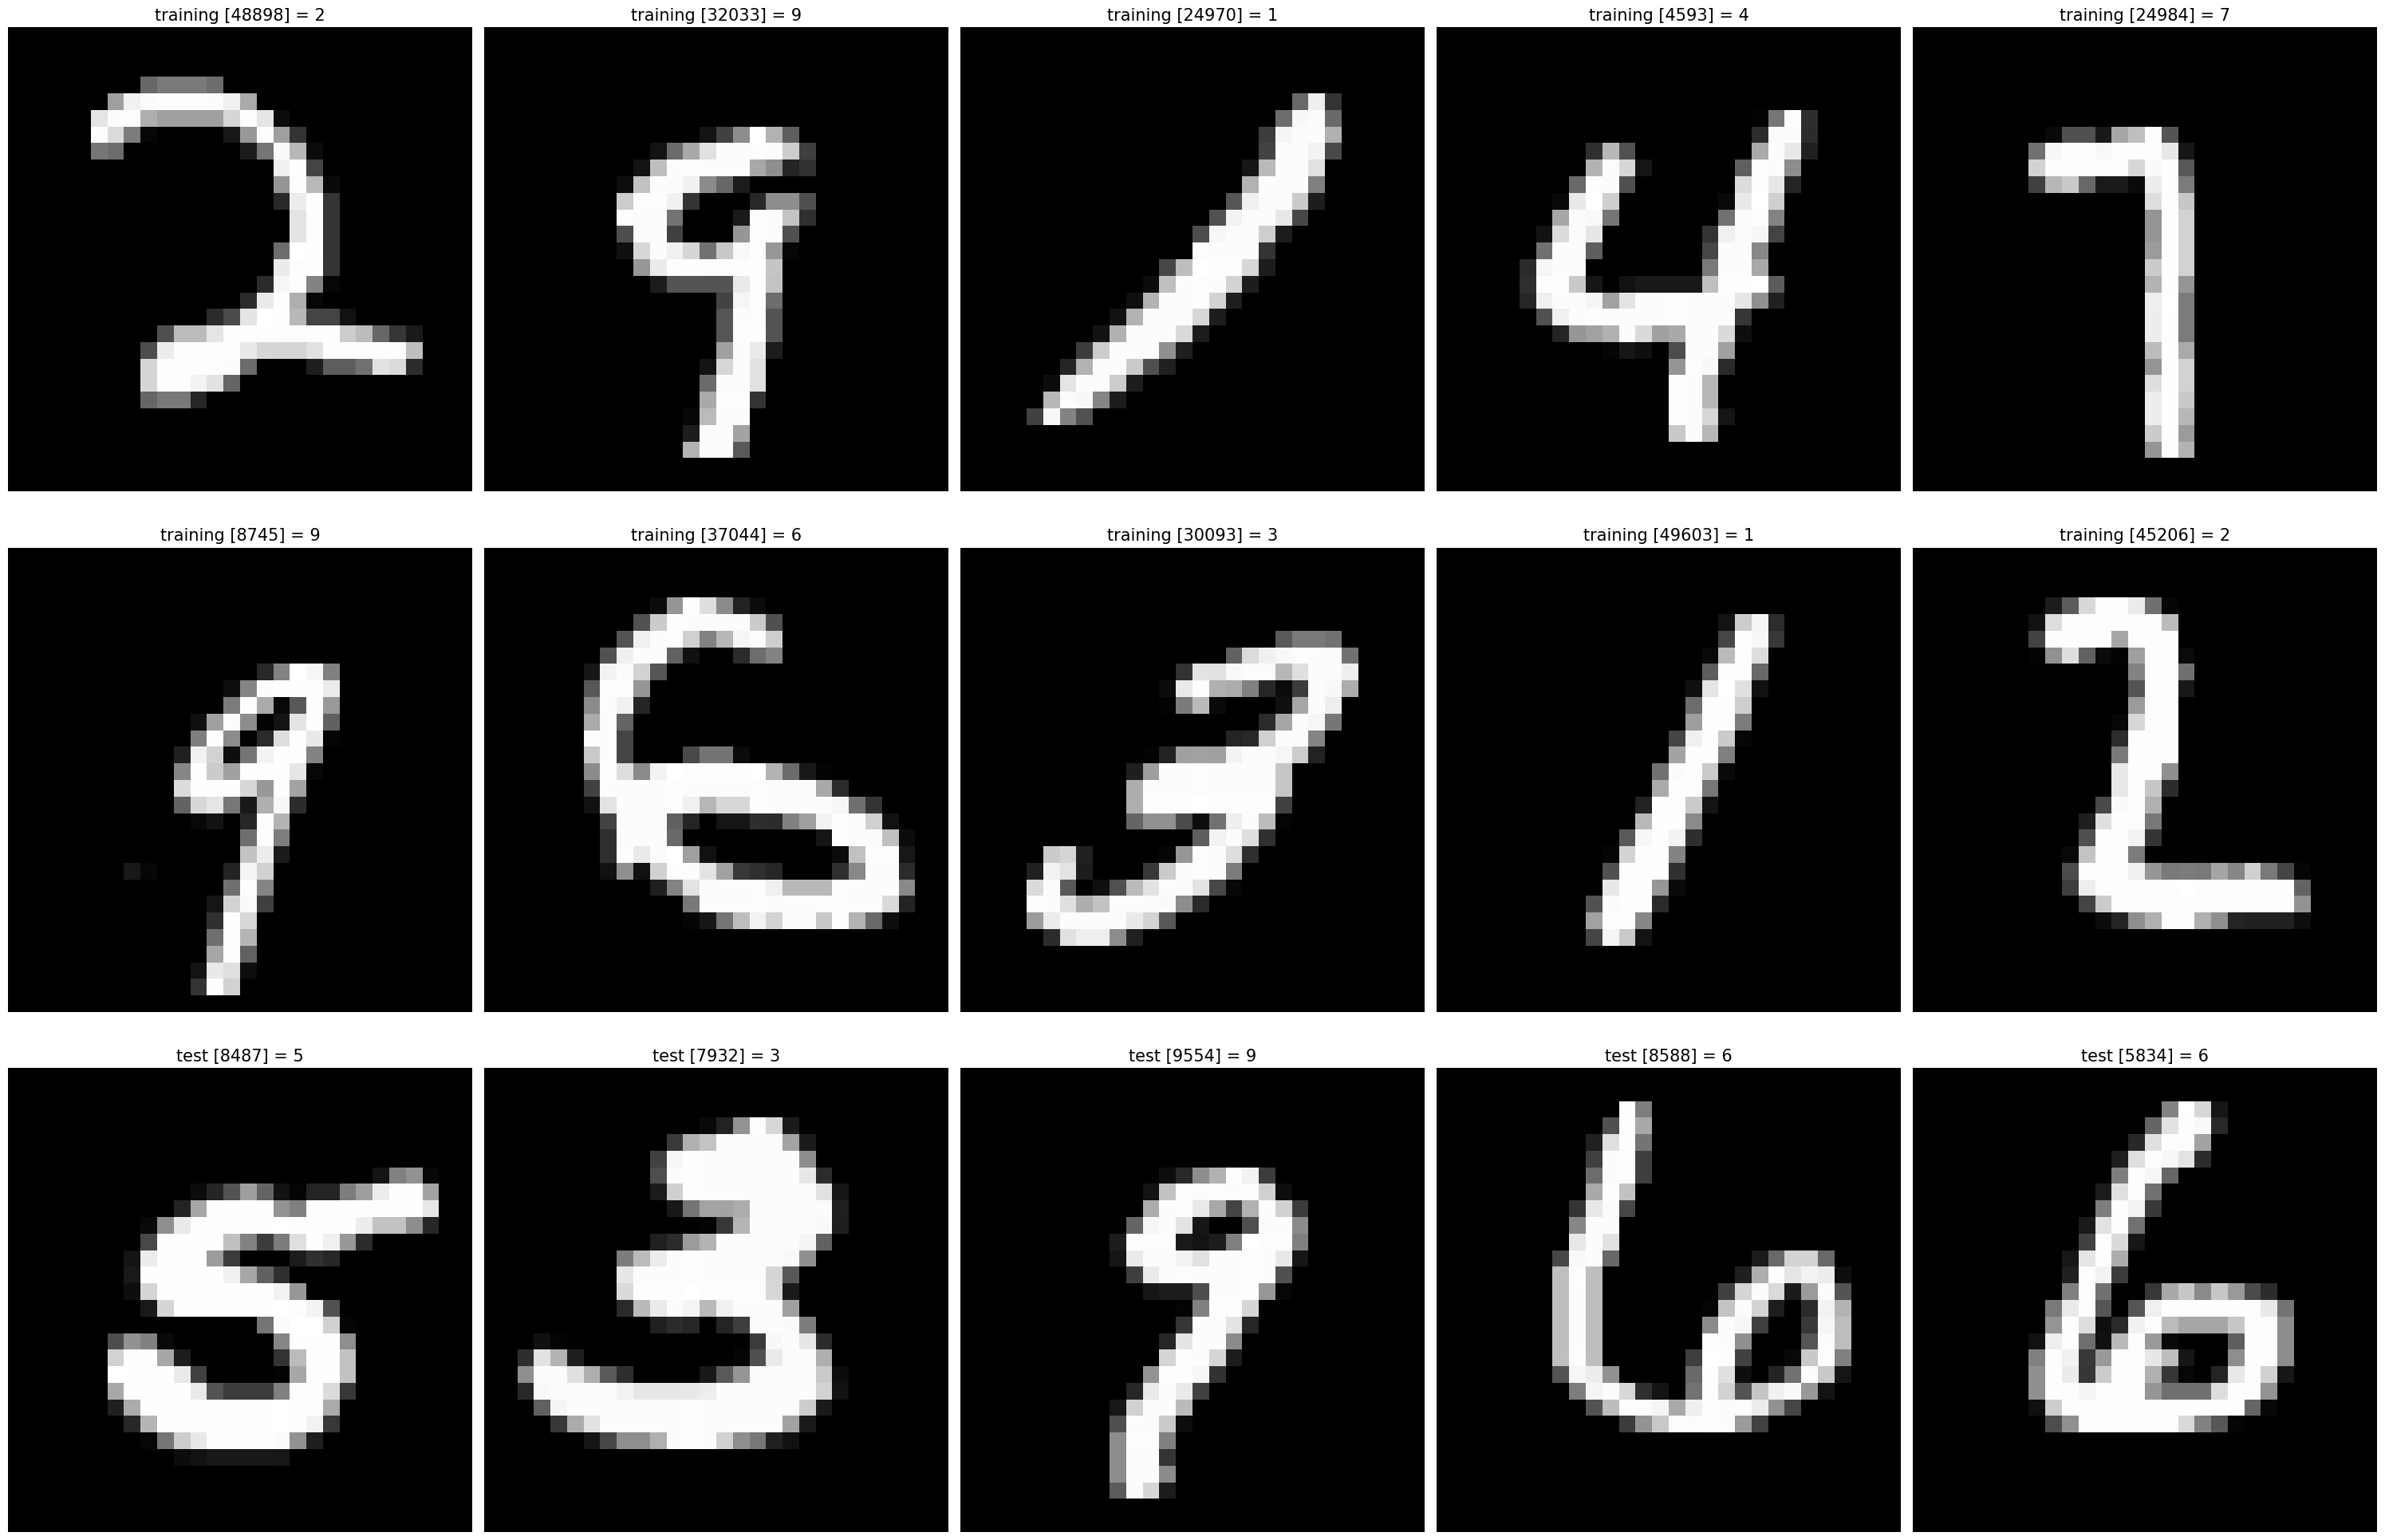

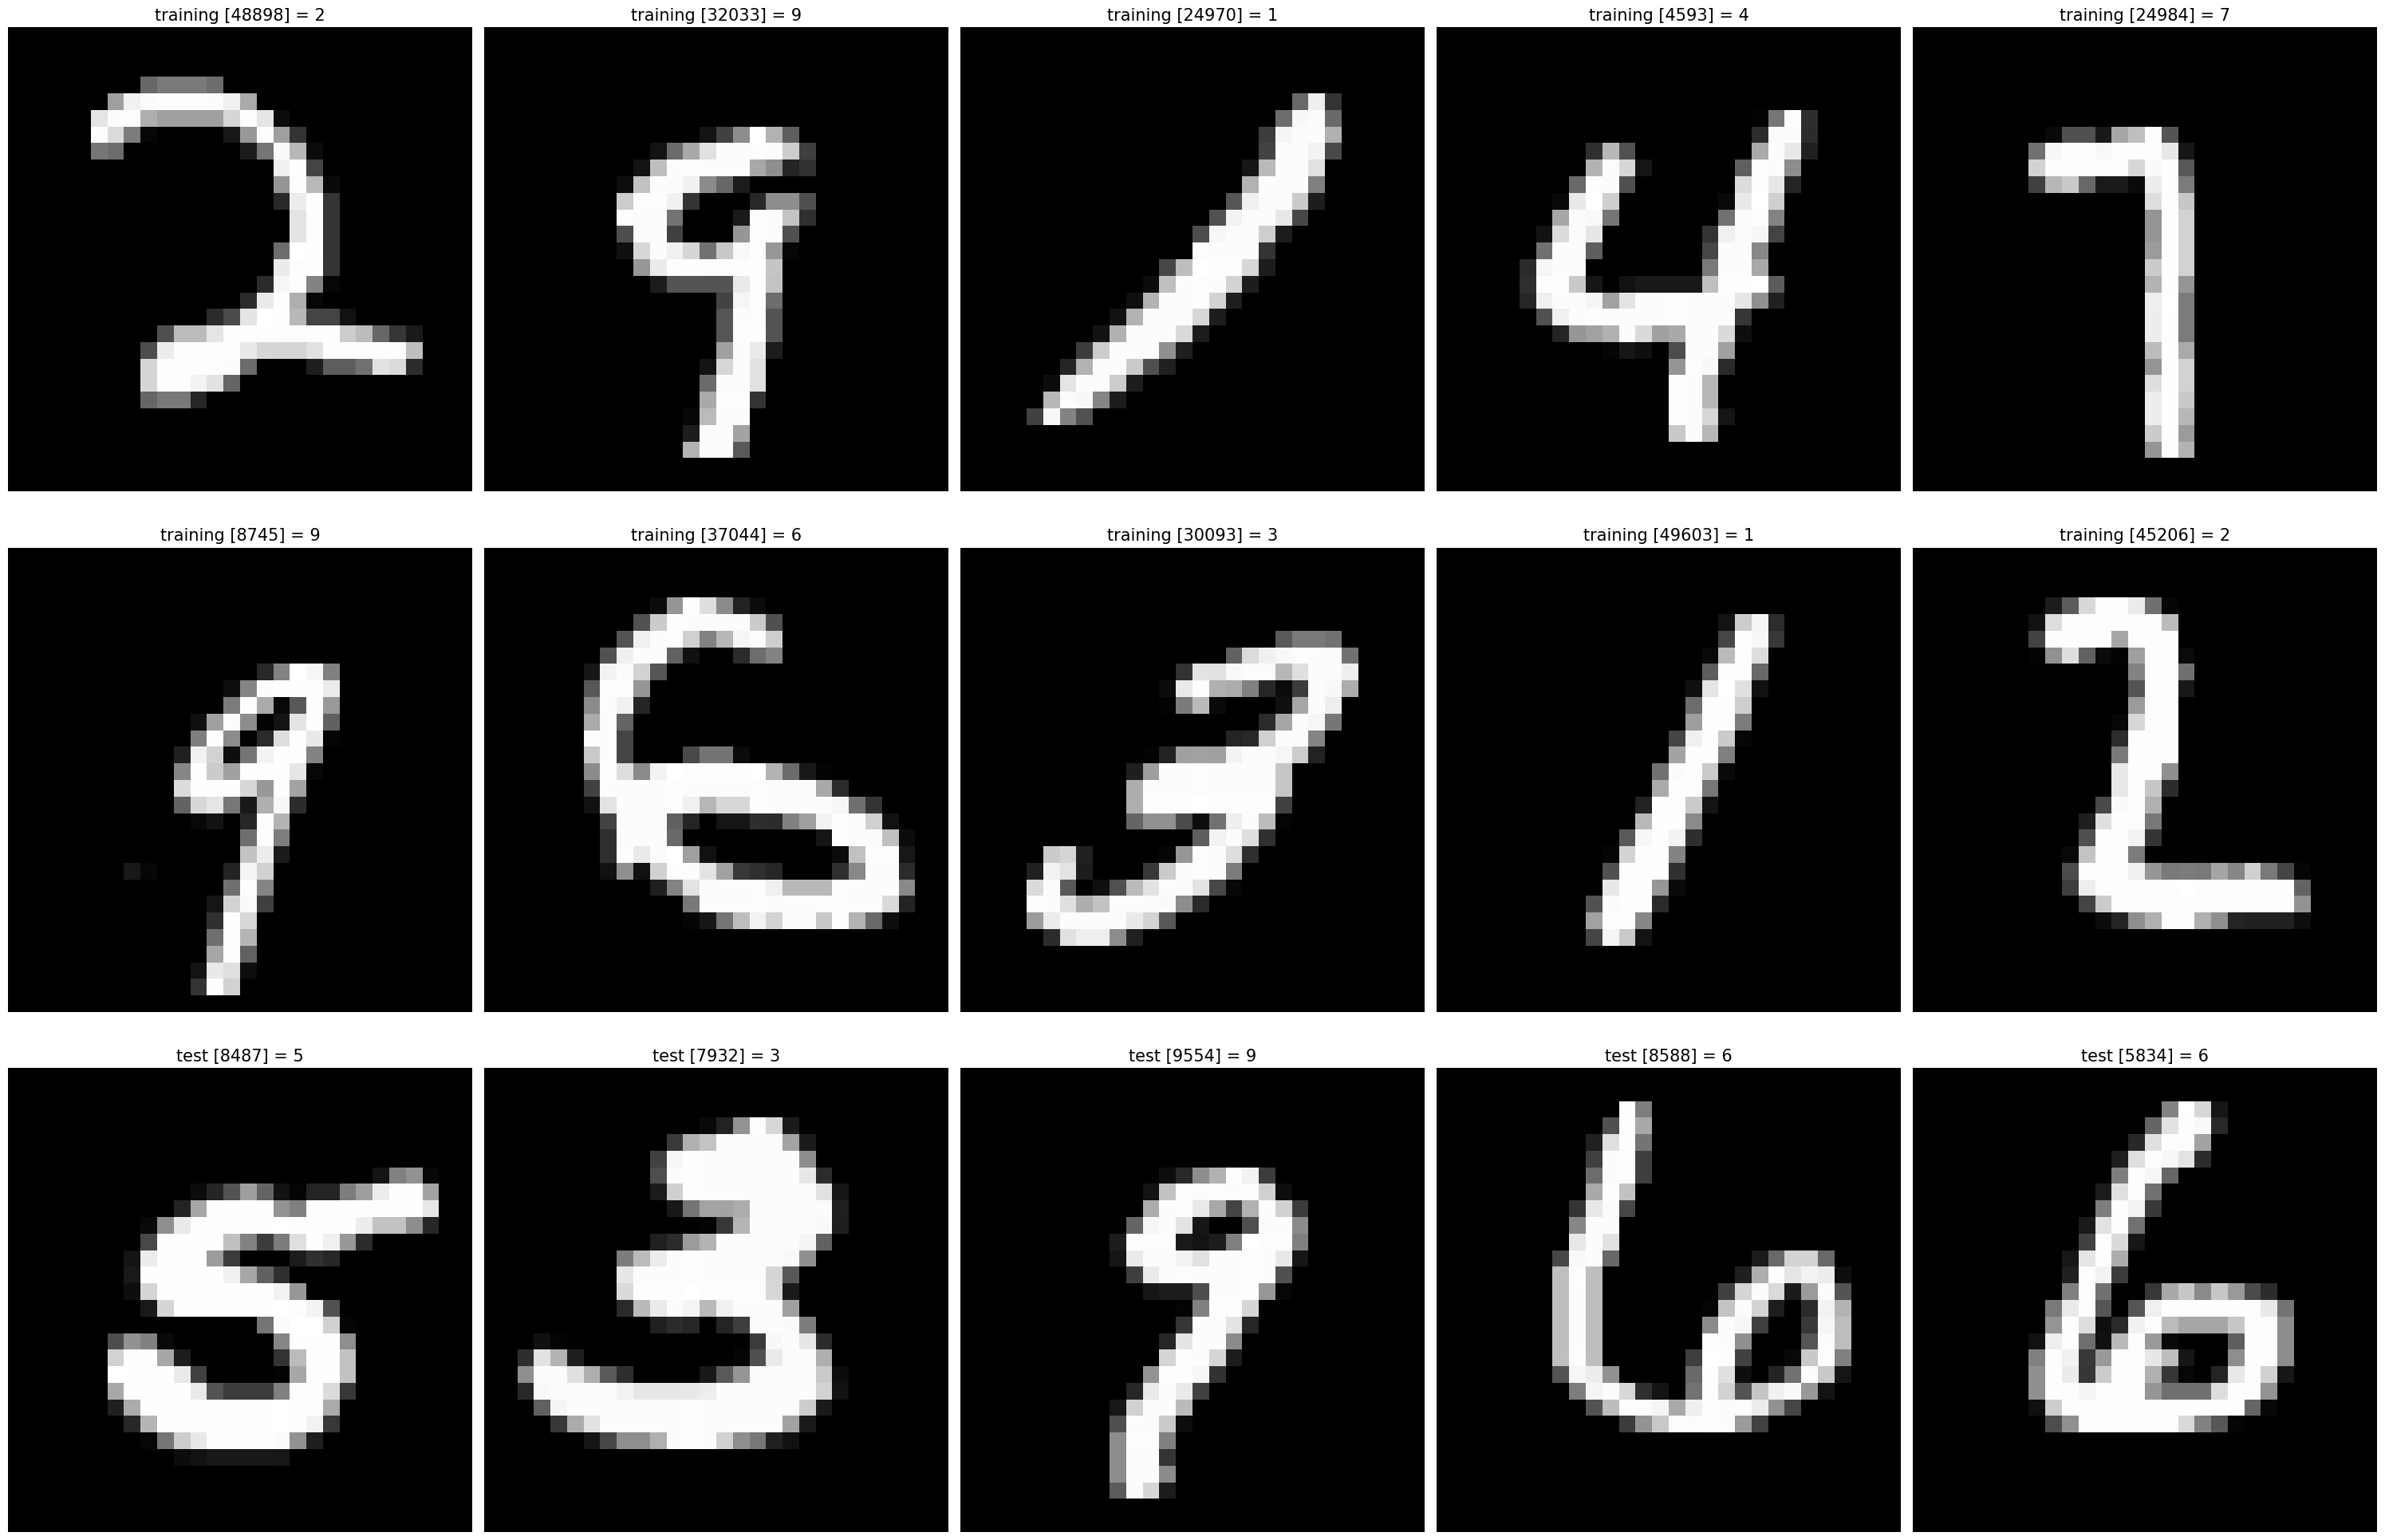

Saved: ../assets/mnist_preview.png


In [2]:
#(from kaggle)
# This is a sample Notebook to demonstrate how to read "MNIST Dataset"
#
import numpy as np # linear algebra
import struct
from array import array
from os.path  import join

#
# MNIST Data Loader Class
#
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        labels = []
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())        
        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  
    
#
# Verify Reading Dataset via MnistDataloader class
#

import os
import random
import matplotlib.pyplot as plt

#
# Set file paths based on added MNIST Datasets
#
input_path = './data/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte')


def save_images_grid(images, title_texts, out_path="assets/samples.png", cols=5, figsize=(30, 20), dpi=150):
    # Crée le dossier si besoin
    os.makedirs(os.path.dirname(out_path) or ".", exist_ok=True)

    rows = (len(images) + cols - 1) // cols  # division plafond
    plt.figure(figsize=figsize)

    for idx, (image, title_text) in enumerate(zip(images, title_texts), start=1):
        plt.subplot(rows, cols, idx)
        plt.imshow(image, cmap=plt.cm.gray)
        if title_text:
            plt.title(title_text, fontsize=15)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig(out_path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close() 
    return out_path


# Load MNIST dataset
mnist_dataloader = MnistDataloader(
    training_images_filepath, training_labels_filepath,
    test_images_filepath, test_labels_filepath
)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

# Collect random training and test images
images_2_show = []
titles_2_show = []

for _ in range(10):
    r = random.randint(0, len(x_train) - 1)
    images_2_show.append(x_train[r])
    titles_2_show.append(f"training [{r}] = {y_train[r]}")

for _ in range(5):
    r = random.randint(0, len(x_test) - 1)
    images_2_show.append(x_test[r])
    titles_2_show.append(f"test [{r}] = {y_test[r]}")

# Save instead of show
path = save_images_grid(images_2_show, titles_2_show, out_path="assets/mnist_preview.png")
path = save_images_grid(images_2_show, titles_2_show, out_path="../assets/mnist_preview.png")
print("Saved:", path)



We saw in Part 1 and Part 2 how to create an MLP from scratch, allowing us to fully understand how they work. So in this part, we are going to see how to do it much faster using PyTorch. 

In this way we can fully concentrate on pre-processing our data and improving our previous methods to solve potential problems.